In [1]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, END, START
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
import json

# Step1 定义状态：所谓状态指在整个流程中需要跟踪的信息
class EmailState(TypedDict):
    # 电子邮件
    email: Dict[str, Any]  # 包含主题、发件人、正文等。
    
    # 是否是垃圾邮件
    is_spam: Optional[bool]

    # 垃圾邮件原因
    spam_reason: Optional[str]  

    # 邮件分类
    email_category: Optional[str]   
    
    # 回复草稿
    draft_response: Optional[str]
    
    # 对话记录
    messages: List[Dict[str, Any]]  # 跟踪与 LLM 的对话以进行分析

# Step2 初始化大模型
model = ChatOpenAI(
    base_url="https://api-inference.modelscope.cn/v1/",
    api_key="954a12f1-1c3f-4756-b133-248866adfd7b",
    model="Qwen/Qwen2.5-32B-Instruct",
    temperature=0
)

# Step3 定义节点
def read_email(state: EmailState):
    """读取并打印邮件"""
    email = state["email"]
    
    # 在这里我们可能会做一些初步的预处理
    print(f"""收到邮件\n发件人：{email['sender']}\n主题：{email['subject']}""")
    
    # 这里不需要更改状态
    return {}

def classify_email(state: EmailState):
    """使用LLM对邮件进行分类"""
    email = state["email"]
    
    # 为 LLM 准备提示
    prompt = f"""
    分析这封电子邮件并判断它是垃圾邮件还是合法邮件
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    只返回JSON，格式如下
    {{
        "is_spam":"spam or legitimate",
        "spam_reason":"If it is spam, explain why, in chinese"
        "email_category":"If it is legitimate, categorize it (inquiry, complaint, thank you, request, information)"
    }}
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # 解析响应的简单逻辑（在实际应用中，您需要更强大的解析）
    response_json = json.loads(response.content)
    
    # 更新消息以进行追踪
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    # 返回状态更新
    return {
        "is_spam": "spam" == response_json["is_spam"],
        "spam_reason": response_json["spam_reason"],
        "email_category": response_json["email_category"],
        "messages": new_messages
    }

def handle_spam(state: EmailState):
    """处理垃圾邮件"""
    print(f"邮件被标记为垃圾邮件. 原因: {state['spam_reason']}")
    print("邮件被移至垃圾邮件夹.")
    
    # 我们已处理完这封电子邮件
    return {}

def draft_response(state: EmailState):
    """为合法邮件起草初步回复"""
    email = state["email"]
    category = state["email_category"] or "general"
    
    # 为 LLM 准备提示词
    prompt = f"""
    为此邮件起草一封礼貌的初步回复
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    This email has been categorized as: {category}
    
    起草一封简短、专业的回复，供F先生审阅并个性化后发送。
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # 更新消息以进行追踪
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    # 返回状态更新
    return {
        "draft_response": response.content,
        "messages": new_messages
    }

def notify_mr_f(state: EmailState):
    """通知F先生有关邮件的内容，并提交了草稿回复"""
    email = state["email"]
    
    print("\n" + "="*50)
    print(f"F先生, 收到了一封来自 {email['sender']} 的邮件.")
    print(f"主题: {email['subject']}")
    print(f"分类: {state['email_category']}")
    print("\n我已经准备了一份草稿回复供您审阅:")
    print("-"*50)
    print(state["draft_response"])
    print("="*50 + "\n")
    
    # 我们已处理完这封电子邮件
    return {}

# Step4 定义路由逻辑
def route_email(state: EmailState) -> str:
    """Determine the next step based on spam classification"""
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"
    
# Step5 创建 StateGraph 并定义边（将所有内容连接在一起）
# 创建 graph
email_graph = StateGraph(EmailState)

# 添加 nodes
email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("drafting_response", draft_response)
email_graph.add_node("notify_mr_f", notify_mr_f)

# 添加 edges - 定义流程
email_graph.add_edge(START, "read_email")
email_graph.add_edge("read_email", "classify_email")

# 从 classify_email 添加条件分支
email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "drafting_response"
    }
)

# 添加最后的 edges
email_graph.add_edge("handle_spam", END)
email_graph.add_edge("drafting_response", "notify_mr_f")
email_graph.add_edge("notify_mr_f", END)

# 编译 graph
compiled_graph = email_graph.compile()

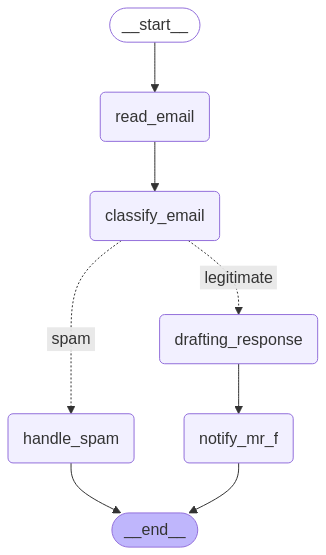

In [2]:
from IPython.display import Image, display
display(Image(compiled_graph.get_graph().draw_mermaid_png()))